## EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
mbti = pd.read_csv('data/train.csv')

# List of mbti types 
type_labels = ['ISTJ', 'ISFJ', 'INFJ', 'INTJ', 
               'ISTP', 'ISFP', 'INFP', 'INTP', 
               'ESTP', 'ESFP', 'ENFP', 'ENTP', 
               'ESTJ', 'ESFJ', 'ENFJ', 'ENTJ']

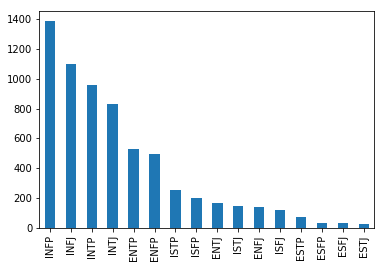

In [3]:
mbti['type'].value_counts().plot(kind = 'bar')


Lets increase the size of the dataset by converting each of the 50 posts into the `posts` column into its own row.

In [4]:

all_mbti = []
for i, row in mbti.iterrows():
    for post in row['posts'].split('|||'):
        all_mbti.append([row['type'], post])
all_mbti = pd.DataFrame(all_mbti, columns=['type', 'post'])

In [5]:
print(f"before:  {mbti.shape} \nafter: {all_mbti.shape}")

before:  (6506, 2) 
after: (316548, 2)


In [6]:
pd.concat([mbti['type'].value_counts().to_frame(name='before'), all_mbti['type'].value_counts().to_frame(name='after')],axis=1)

,before,after
ENFJ,143,6947
ENFP,496,23925
ENTJ,167,8174
ENTP,530,26017
ESFJ,35,1668
ESFP,36,1663
ESTJ,30,1495
ESTP,71,3437
INFJ,1100,53807
INFP,1386,67846


In [7]:
all_mbti.head()

,type,post
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw
1,INFJ,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...
2,INFJ,enfp and intj moments https://www.youtube.com...
3,INFJ,What has been the most life-changing experienc...
4,INFJ,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...


### Note: find out sampling with replacement

---

---
## create features


 feature | regex
 ---|---
 `?`   | `r"(\?)"`
 `!`   | `r"(!)"`
 `...` | `r"(\.\.\.)"`
 youtube | ?part of social media
 www | `r"(www)"`
 jpg/jpeg/gif | <code>r"(jpe?g&#124;gif)"</code>
 emoji `;), :tongue:, :smile: #hastags?` | `r":[a-z]*:"`
 word count   | (\w+) / 50 (length per post sample)
 word_length > 5   | `r"(\w{5,})"`
 social_media (instagram, snapchat, etc)  | [social_medai]
 ALL_CAPS  | `r"(\b[A-Z]{2,}\b)"`


In [8]:
import re

# count question marks
def qm_count(string):
    q_mark = re.compile(r'(\?)')
    return len(re.findall(q_mark, string))
    

def exclaim_count(string):
    ex_mark = re.compile(r'(\!)')
    return len(re.findall(ex_mark, string))

def elipse_count(string):
    elipse = re.compile(r"(\.\.\.)")
    return len(re.findall(elipse, string))

def emoji_count(string):
    emojis = re.compile(r"(:[a-z]*:)|([:;][()pdo03])",re.I)
    return len(re.findall(emojis,string))

def word_count(string):
    words = re.compile(r"(\w+)")
    count = len(re.findall(words, string))
    return count

def word_len(string):
    len5 = re.compile(r"\w{5,}")
    return len(re.findall(len5,string))

def all_caps(string):
    mbti_type = set(all_mbti.type) # set of all mbti types
    capsloc = re.compile(r"\b[A-Z]{2,}\b")
    caps_words = [x for x in re.findall(capsloc,string) if x not in mbti_type]
    return len(caps_words)

def count_pix(string):
    pix = re.compile(r"\b(jpe?g|gif|png|img)\b",re.I)
    return len(re.findall(pix, string))

either leave all above functions as is (easier to test)

or put it all in one function with flags to call each one

In [17]:
def create_features(df):
    df['questions'] = df['post'].apply(qm_count)
    df['exclaimed'] = df['post'].apply(exclaim_count)
    df['elipses'] = df['post'].apply(elipse_count)
    df['emojis'] = df['post'].apply(emoji_count)
    df['word_count'] = df['post'].apply(word_count)
    df['big_words'] = df['post'].apply(word_len)
    df['images'] = df['post'].apply(count_pix)    
    df['words_all_caps'] = df['post'].apply(all_caps) 

In [18]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore") # ignore warning messages cluttering up view
    create_features(all_mbti)

KeyboardInterrupt: 

In [43]:
all_mbti.head(10)

,type,post,questions,exclaimed,elipses,emojis,word_count,big_words,images,words_all_caps
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw,1,0,0,0,7,3,0,0
1,INFJ,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...,0,0,0,0,7,3,1,0
2,INFJ,enfp and intj moments https://www.youtube.com...,2,0,0,0,24,12,0,0
3,INFJ,What has been the most life-changing experienc...,1,0,0,0,11,2,0,0
4,INFJ,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...,2,0,0,0,20,8,0,0
5,INFJ,May the PerC Experience immerse you.,0,0,0,0,6,2,0,0
6,INFJ,The last thing my INFJ friend posted on his fa...,0,0,0,0,23,10,0,0
7,INFJ,Hello ENFJ7. Sorry to hear of your distress. I...,0,0,1,0,38,14,0,0
8,INFJ,84389 84390 http://wallpaperpassion.com/uplo...,0,0,1,0,26,13,2,0
9,INFJ,Welcome and stuff.,0,0,0,0,3,2,0,0


In [45]:
# save as it took MEGA long
all_mbti.to_csv('data/all_mbti_feat.csv')

---

In [19]:
all_mbti= pd.read_csv('data/all_mbti_feat.csv').drop('Unnamed: 0', axis=1)
all_mbti.head()

,type,post,questions,exclaimed,elipses,emojis,word_count,big_words,images,words_all_caps
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw,1,0,0,0,7,3,0,0
1,INFJ,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...,0,0,0,0,7,3,1,0
2,INFJ,enfp and intj moments https://www.youtube.com...,2,0,0,0,24,12,0,0
3,INFJ,What has been the most life-changing experienc...,1,0,0,0,11,2,0,0
4,INFJ,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...,2,0,0,0,20,8,0,0


In [20]:
def split_type(row):
    ''' 
       Split MBTI type into individual features for Binary Classification
       eg ENFP = [0 1 0 0]
    '''
    t = row['type']
    I,N,T,J = 0,0,0,0
    
    I = 1 if t[0] =='I' else 0
    
    N = 1 if t[1] == 'N' else 0
    
    T = 1 if t[2] == 'T' else 0
    
    J = 1 if t[3] == 'J' else 0
    
    return pd.Series( {'IE':I, 'NS':N , 'TF': T, 'JP': J }) 

In [21]:
all_mbti = all_mbti.join(all_mbti.apply(lambda row: split_type(row), axis=1))
all_mbti.head(5)

,type,post,questions,exclaimed,elipses,emojis,word_count,big_words,images,words_all_caps,IE,JP,NS,TF
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw,1,0,0,0,7,3,0,0,1,1,1,0
1,INFJ,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...,0,0,0,0,7,3,1,0,1,1,1,0
2,INFJ,enfp and intj moments https://www.youtube.com...,2,0,0,0,24,12,0,0,1,1,1,0
3,INFJ,What has been the most life-changing experienc...,1,0,0,0,11,2,0,0,1,1,1,0
4,INFJ,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...,2,0,0,0,20,8,0,0,1,1,1,0


### FeatureUnion to add created features to the data pipeline

https://www.kaggle.com/adamschroeder/countvectorizer-tfidfvectorizer-predict-comments/code

http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html

#### my own stopwords list

In [22]:
my_stopwords = ['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren',
"aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can',
'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't",
'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't",
'have', 'haven', "haven't", 'having',  'how', 'if', 'in', 'into', 'is', 'isn', "isn't", 'it', "it's", 'its',
'itself', 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'needn',
"needn't", 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't",
'she', "she's", 'should', "should've",'shouldn', "shouldn't", 'so', 'some', 'such', 't', 'than', 'that', "that'll", 'the', 'then',
'there', 'these', 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 've', 'very', 'was', 'wasn', "wasn't", 'we',
'were', 'weren', "weren't", 'what', 'when', 'where', 'which', 'while', 'who', 'whom', 'why', 'will', 'with', 'won', "won't",
'wouldn', "wouldn't", 'y','ISTJ', 'ISFJ', 'INFJ', 'INTJ', 'ISTP', 'ISFP', 'INFP', 'INTP', 'ESTP', 'ESFP', 'ENFP', 'ENTP', 'ESTJ',
'ESFJ', 'ENFJ', 'ENTJ']

In [23]:
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import FunctionTransformer

from sklearn.pipeline import FeatureUnion

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.preprocessing import MinMaxScaler

# classifiers
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [58]:
# function to select all numeric data (created features) to be used in pipeline
get_numeric_data = FunctionTransformer(lambda df: df.iloc[:,2:], validate=False) # we will validate
get_text_data    = FunctionTransformer(lambda df: df.iloc[:,1], validate=False) # we will validate

In [175]:
def get_numeric_data(X):
    return X.iloc[:,2:]

In [176]:
def get_text_data(X):
    return X.iloc[:,1]

In [76]:
all_mbti.columns

Index(['type', 'post', 'questions', 'exclaimed', 'elipses', 'emojis',
       'word_count', 'big_words', 'images', 'words_all_caps'],
      dtype='object')

In [25]:
from sklearn.base import TransformerMixin, BaseEstimator

In [25]:
class get_numeric_col(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        num_cols = X[self.cols]
        return num_cols

In [25]:
class get_text_col(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        text_col = X[self.cols]
        return text_col

In [25]:
#num_cols = ['big_words']

In [25]:
num_cols = ['questions', 'exclaimed', 'elipses', 'emojis',
       'word_count', 'big_words', 'images', 'words_all_caps']

In [25]:
text_col = ['post']

In [25]:
numeric_pipeline  = Pipeline([('num_data', get_numeric_col(num_cols)),
                              ('scaler', MinMaxScaler()),
                             ])

In [25]:
text_pipeline = Pipeline([('text_data', get_text_col(text_col)),
                          ('count_vec', CountVectorizer())
                         ])

In [25]:
union = FeatureUnion([
         ('numeric', numeric_pipeline),
         #('num_data', get_numeric_col(num_cols)),
         ('text',text_pipeline)])

In [25]:
main_pipe = Pipeline([
    ('feature', union),
    ('bayes', MultinomialNB())
])

In [241]:
all_mbti.head()

,type,post,questions,exclaimed,elipses,emojis,word_count,big_words,images,words_all_caps,IE,JP,NS,TF
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw,1,0,0,0,7,3,0,0,1,1,1,0
1,INFJ,http://41.media.tumblr.com/tumblr_lfouy03PMA1q...,0,0,0,0,7,3,1,0,1,1,1,0
2,INFJ,enfp and intj moments https://www.youtube.com...,2,0,0,0,24,12,0,0,1,1,1,0
3,INFJ,What has been the most life-changing experienc...,1,0,0,0,11,2,0,0,1,1,1,0
4,INFJ,http://www.youtube.com/watch?v=vXZeYwwRDw8 h...,2,0,0,0,20,8,0,0,1,1,1,0


In [34]:
from sklearn.model_selection import train_test_split

In [83]:
X = all_mbti[['post','questions', 'exclaimed', 'elipses', 'emojis',
       'word_count', 'big_words', 'images', 'words_all_caps']]
y = all_mbti['IE']

In [84]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=42)


In [75]:
X_train.head()

,post,questions,exclaimed,elipses,emojis,word_count,big_words,images,words_all_caps
88298,This one inspires me the same way my INFJ frie...,1,0,0,0,20,6,0,0
80402,"I think that's probably what he's doing, being...",0,0,1,0,39,13,0,0
175838,I wonder if there is a correlation between NT ...,0,0,1,0,35,13,0,1
4744,@OrangeAppled “I certainly adapted to their ...,1,0,1,0,32,15,0,0
279913,Imaginary Numb3r I do like you're description....,0,0,1,0,39,12,0,0


In [85]:
main_pipe.fit(X_train, y_train)

ValueError: blocks[0,:] has incompatible row dimensions. Got blocks[0,1].shape[0] == 1, expected 221583.

In [46]:
y_pred= main_pipe.predict(X_test)

In [47]:
main_pipe.score(X_train,y_train)

0.7691474526475407

In [146]:
numeric_pipeline2.score(X_test,y_test)

0.21353130100563367

In [94]:
from sklearn.metrics import classification_report

In [95]:
print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

       ENFJ       0.00      0.00      0.00      2155
       ENFP       0.66      0.01      0.02      7282
       ENTJ       0.00      0.00      0.00      2449
       ENTP       0.49      0.02      0.03      7831
       ESFJ       0.00      0.00      0.00       464
       ESFP       0.00      0.00      0.00       493
       ESTJ       0.00      0.00      0.00       458
       ESTP       0.00      0.00      0.00      1041
       INFJ       0.26      0.24      0.25     16233
       INFP       0.24      0.86      0.38     20278
       INTJ       0.41      0.07      0.11     11856
       INTP       0.35      0.13      0.19     13981
       ISFJ       0.33      0.00      0.00      1798
       ISFP       1.00      0.00      0.00      2825
       ISTJ       1.00      0.00      0.00      2123
       ISTP       0.71      0.00      0.00      3698

avg / total       0.38      0.25      0.17     94965



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [96]:
from sklearn.metrics import confusion_matrix

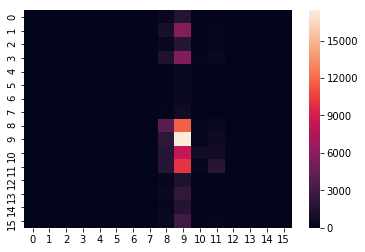

In [97]:
import seaborn as sns
%matplotlib inline
sns.heatmap(confusion_matrix(y_test,y_pred))

---
## Sklearn pipeline, GridSearchCV
```
imports

steps= [('count_vec','CountVectorizer()),
        ('SVM', SVM())]
       
pipeline= Pipeline(steps)

parameters = {'SVM__C': [1,10,100],
              'SVM__gamma': [0.1,0.01]}
              
train, test split

cv = GrisSearchCV(pipeline,parameters) #default cv=5

cv.fit(X_train, y_train)

y_pred = cv.predict(X_test)

"best params" cv.best_params_

"Accuracy" cv.score(X_test,y_test)

classification_report(y_test,y_pred)
```

---